The goal of this notebook is to tie the songs I know into the era that they are from. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np

# Load the music data
df = pd.read_csv('all.csv')

print(f"Total songs: {len(df)}")
print(f"Total unique artists: {df['Artist'].nunique()}")
print(f"Columns: {list(df.columns)}")
print("\nFirst few rows:")
df.head()

Total songs: 2223
Total unique artists: 863
Columns: ['#', 'Song', 'Artist', 'Popularity', 'BPM', 'Genres', 'Album', 'Album Date', 'Time', 'Dance', 'Energy', 'Acoustic', 'Instrumental', 'Happy', 'Speech', 'Live', 'Loud (Db)', 'Key', 'Time Signature', 'Added At', 'Spotify Track Id', 'Camelot', 'ISRC']

First few rows:


,#,Song,Artist,Popularity,BPM,Genres,Album,Album Date,Time,Dance,...,Happy,Speech,Live,Loud (Db),Key,Time Signature,Added At,Spotify Track Id,Camelot,ISRC
0,1,Gabriel Ratchet,Deca,41,82,jazz rap,The Ocean,2013-09-23,03:11,68,...,76,30,10,-5,G Major,4,2025-08-03,4uQjhQYQyVZBKDtve537qZ,9B,TCABQ1315888
1,2,Lifestylez Ov Da Poor & Dangerous,Big L,45,85,"east coast hip hop, old school hip hop, hardco...",Lifestylez Ov Da Poor & Dangerous,1995-03-28,03:21,68,...,40,30,0,-9,D#/E♭ Minor,4,2025-08-03,5GseQckHgP7uWyaiCd5ZW3,2A,USSM10022975
2,3,Danger Zone,Big L,42,171,"east coast hip hop, old school hip hop, hardco...",Lifestylez Ov Da Poor & Dangerous,1995-03-28,03:36,52,...,34,30,20,-11,G Major,4,2025-08-03,0kU9oWqYnPeqEca3x2auV9,9B,USSM10022974
3,4,Hive (feat. Vince Staples & Casey Veggies),"Earl Sweatshirt,Vince Staples,Casey Veggies",55,145,"experimental hip hop, alternative hip hop,",Doris,2013-08-16,04:37,62,...,78,50,10,-7,C♯/D♭ Major,4,2025-08-03,6JKoTnberZoBgUuxa6l4Kh,3B,USQX91301103
4,5,King Kunta,Kendrick Lamar,73,107,"hip hop, west coast hip hop",To Pimp A Butterfly,2015-03-16,03:54,88,...,49,10,10,-5,F#/G♭ Minor,4,2025-08-03,0N3W5peJUQtI4eyR6GJT5O,11A,USUM71502494


In [2]:
# Primary/Clean artist: take first artist before comma
df["Cleaned_Artist"] = df["Artist"].astype(str).str.split(",").str[0].str.strip()

In [3]:
# Bach override when album mentions Bach
mask_bach = df["Album"].astype(str).str.contains("Bach", case=False, na=False)
df.loc[mask_bach, "Cleaned_Artist"] = "Johann Sebastian Bach"

Songs: 2223, with inferred Year: 2045 (92.0%) [source: Album Date]

Counts by decade:
Decade
1930      1
1950     22
1960     96
1970     94
1980     53
1990    205
2000    522
2010    367
2020    685
dtype: int64

Top artists per decade (top 10):

1930s:
  Judy Garland: 1

1950s:
  Ella Fitzgerald: 5
  Julie London: 4
  The Chordettes: 3
  The Four Freshmen: 3
  Charlie Parker: 2
  Nat King Cole: 2
  Miles Davis: 2
  João Gilberto: 1

1960s:
  The Beatles: 30
  The Beach Boys: 20
  Stan Getz: 5
  The Doors: 4
  Bob Dylan: 3
  Simon & Garfunkel: 2
  The Monkees: 2
  Wolfgang Amadeus Mozart: 2
  Nat King Cole: 2
  Louis Armstrong: 2

1970s:
  Steely Dan: 9
  Elton John: 7
  Billy Joel: 5
  Queen: 5
  Electric Light Orchestra: 4
  Stevie Wonder: 4
  Bruce Springsteen: 3
  Earth: 3
  Neil Young: 2
  Bob Dylan: 2

1980s:
  Pixies: 6
  Tears For Fears: 5
  Ludwig van Beethoven: 4
  The Tallis Scholars: 3
  Billy Joel: 3
  Erasure: 2
  Duran Duran: 2
  Michael Jackson: 2
  Johann Sebastian B

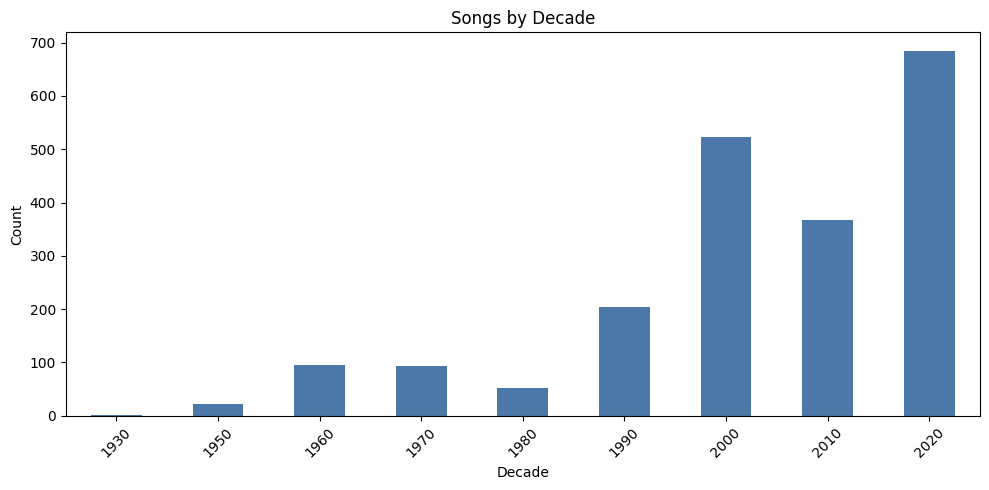

In [7]:
# Year & Decade inference + report (concise)
import re

# Candidate year/date columns sorted by preference
candidates = [
    "Album Date",  # dataset column
    "Release Date",
    "Released",
    "Album Year",
    "ReleaseYear",
    "Year",
    "Date",
]
existing = [c for c in candidates if c in df.columns]

used_column = None
for col in existing:
    # try datetime -> year
    s = pd.to_datetime(df[col], errors="coerce", utc=True).dt.year
    # fallback: numeric in plausible range
    if s.notna().sum() == 0:
        n = pd.to_numeric(df[col], errors="coerce")
        s = n.where((n >= 1800) & (n <= 2099))
    if s.notna().sum() > 0:
        df["Year"] = s
        used_column = col
        break

# Regex fallback from textual columns
if used_column is None:
    text = df[[c for c in ["Album", "Song", "Title", "Track", "Name"] if c in df.columns]]\
            .astype(str).agg(" ".join, axis=1)
    found = text.str.extract(r"((?<!\d)(18|19|20)\d{2}(?!\d))", expand=True)[0]
    df["Year"] = pd.to_numeric(found, errors="coerce")
    if df["Year"].notna().sum() > 0:
        used_column = "regex(Album/Song)"

# Decade
df["Decade"] = (pd.to_numeric(df["Year"], errors="coerce") // 10 * 10).astype("Int64")

# Report
total = len(df)
with_year = df["Year"].notna().sum()
print(f"Songs: {total}, with inferred Year: {with_year} ({(with_year/total if total else 0):.1%}) [source: {used_column or 'none'}]")

# Decade distribution
decade_counts = df.dropna(subset=["Decade"]).groupby("Decade").size().sort_index()
print("\nCounts by decade:")
print(decade_counts)

# Top artists per decade (top 10 for quick scan)
artist_col = "Cleaned_Artist" if "Cleaned_Artist" in df.columns else "PrimaryArtist"
by_decade = (
    df.dropna(subset=["Decade"]) 
      .groupby(["Decade", artist_col]).size()
      .sort_values(ascending=False)
      .groupby(level=0).head(10)
)
print("\nTop artists per decade (top 10):")
for decade, chunk in by_decade.groupby(level=0):
    print(f"\n{int(decade)}s:")
    for (d, a), cnt in chunk.items():
        print(f"  {a}: {cnt}")

# Plot
plt.figure(figsize=(10, 5))
decade_counts.plot(kind="bar", color="#4C78A8")
plt.title("Songs by Decade")
plt.xlabel("Decade")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()